In [1]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import reshape_as_image
import fiona
import shapely
import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
xgb.set_config(verbosity=2)

In [2]:
def read_n_preprocess(im_path=None):
    '''
        Input: image and mask path
        Return: flatten feature and label to feed into classifier
    '''
    with fiona.open(im_path.replace(".tif",".shp"), "r") as shapefile:        
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(im_path) as src:
        data = src.read()
        out_meta = src.meta
        mask = rasterio.features.geometry_mask(shapes, (src.height, src.width), src.transform, invert=True, all_touched=True).astype('uint8')
    feature = data.reshape(4,-1).swapaxes(0,1)
    label = (mask).flatten()
    return feature, label, data.shape[1:3], out_meta

In [3]:
from sklearn.model_selection import train_test_split

img_path = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/final_data/clip_1/clip_1.tif"
img_path2 = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/final_data/clip_2/clip_2.tif"
img_path3 = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/final_data/clip_3/clip_3.tif"

num_samples = 10000000
feature, label, shape1, meta1 = read_n_preprocess(img_path2)

X_train, X_val, y_train, y_val = train_test_split(feature, label, test_size=0.1, random_state=123)

In [4]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y = y_train #provide your own target name
)

In [5]:
from sklearn.metrics import jaccard_score, f1_score, mean_absolute_error, auc

xg_class = xgb.XGBClassifier(objective = "binary:logistic", #multi:softmax
    max_depth = 6, n_estimators = 200, learning_rate = 0.01,
    min_child_weight= 1, colsample_bytree = 0.8,
    scale_pos_weight= 1,  silent = False,
    verbosity = 2, random_state = 24,
    gpu_id =0, tree_method= 'gpu_hist', predictor="gpu_predictor"
    # eval_metric = jaccard_score#, early_stopping_rounds=1000 #,callbacks
)

# xg_class = xgb.XGBClassifier(objective = "binary:logistic", #multi:softmax
#     max_depth = 6, n_estimators = 200, learning_rate= 0.03,
#     min_child_weight= 1, colsample_bytree= 0.8,
#     scale_pos_weight= 1, gpu_id =0, tree_method= 'gpu_hist', silent = False,
#     verbosity = 2, random_state = 24
# )

In [9]:
xg_class.base_score

None


In [7]:
xg_class.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_val, y_val)], eval_metric="auc")

/home/skymap/anaconda3/envs/store/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[11:34:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562897727/work/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.98883
[1]	validation_0-auc:0.98893
[2]	validation_0-auc:0.99247
[3]	validation_0-auc:0.99279
[4]	validation_0-auc:0.99275
[5]	validation_0-auc:0.99282
[6]	validation_0-auc:0.99286
[7]	validation_0-auc:0.99288
[8]	validation_0-auc:0.99308
[9]	validation_0-auc:0.99308
[10]	validation_0-auc:0.99311
[11]	validation_0-auc:0.99314
[12]	validation_0-auc:0.99315
[13]	validation_0-auc:0.99313
[14]	validation_0-auc:0.99314
[15]	validation_0-auc:0.99328
[16]	validation_0-auc:0.99329
[17]	validation_0-auc:0.99331
[18]	validation_0-auc:0.99332
[19]	valid

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='gpu_predictor',
              random_state=24, reg_alpha=0, reg_lambda=1, ...)

In [ ]:
xg_class.evals_result()

In [10]:
from sklearn.metrics import jaccard_score, f1_score, auc, roc_curve

img_path2 = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/final_data/clip_2/clip_2.tif"
feature2, label2, shape2, meta2 = read_n_preprocess(img_path2)
y_pred2 = xg_class.predict(feature2)

fpr, tpr, thresholds = roc_curve(y, pred, pos_label=2)
jaccard_score(label2, y_pred2, average='weighted'),f1_score(label2, y_pred2, average='weighted'), auc(label2, y_pred2)/(shape2[0]*shape2[1])

(0.9507509703911331, 0.974752581344284, 0.14536525278643037)

In [ ]:
from sklearn.metrics import jaccard_score, f1_score

img_path2 = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/final_data/clip_2/clip_2.tif"
feature2, label2 = read_n_preprocess(img_path2)
y_pred2 = xg_class.predict(feature2)

jaccard_score(label2, y_pred2, average='weighted'),f1_score(label2, y_pred2, average='weighted')

(0.9348400946516825, 0.9663207625215295)

In [ ]:
from sklearn.metrics import jaccard_score, f1_score

img_path2 = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/final_data/clip_2/clip_2.tif"
feature2, label2 = read_n_preprocess(img_path2)
y_pred2 = xg_class.predict(feature2)

jaccard_score(label2, y_pred2, average='weighted'),f1_score(label2, y_pred2, average='weighted')

(0.9298375312969317, 0.9636397586059166)

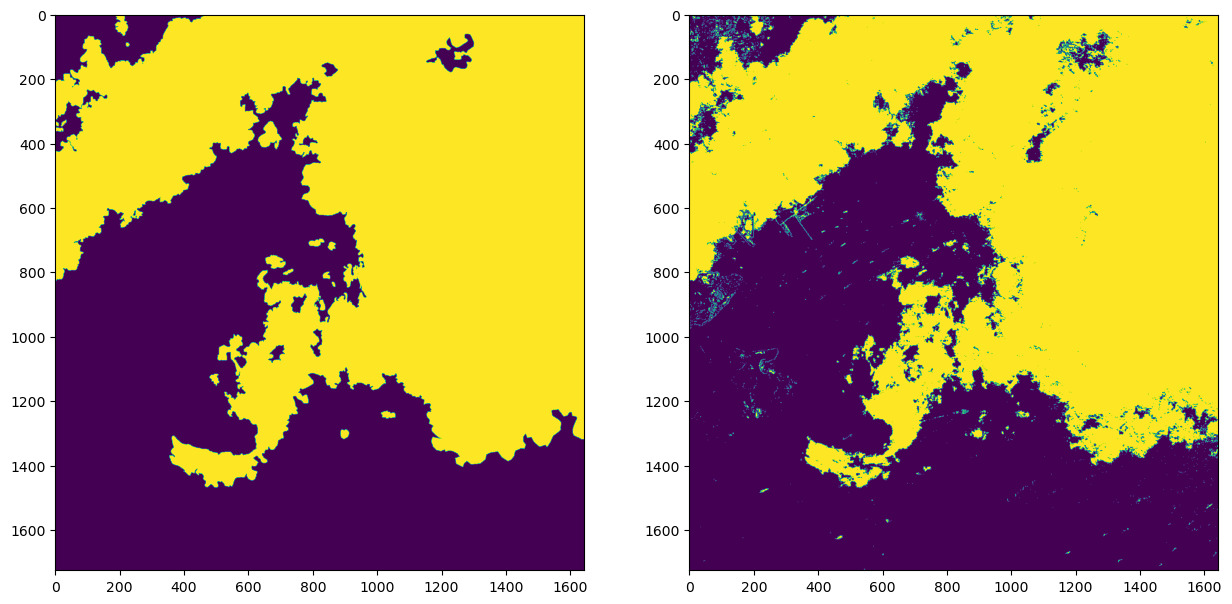

In [64]:
new_mask2 = y_pred2.reshape(shape2)

plt.figure(figsize=(15,15), dpi=100)
plt.subplot(1,2,1)
plt.imshow(label2.reshape(shape2))

plt.subplot(1,2,2)
plt.imshow(new_mask2)

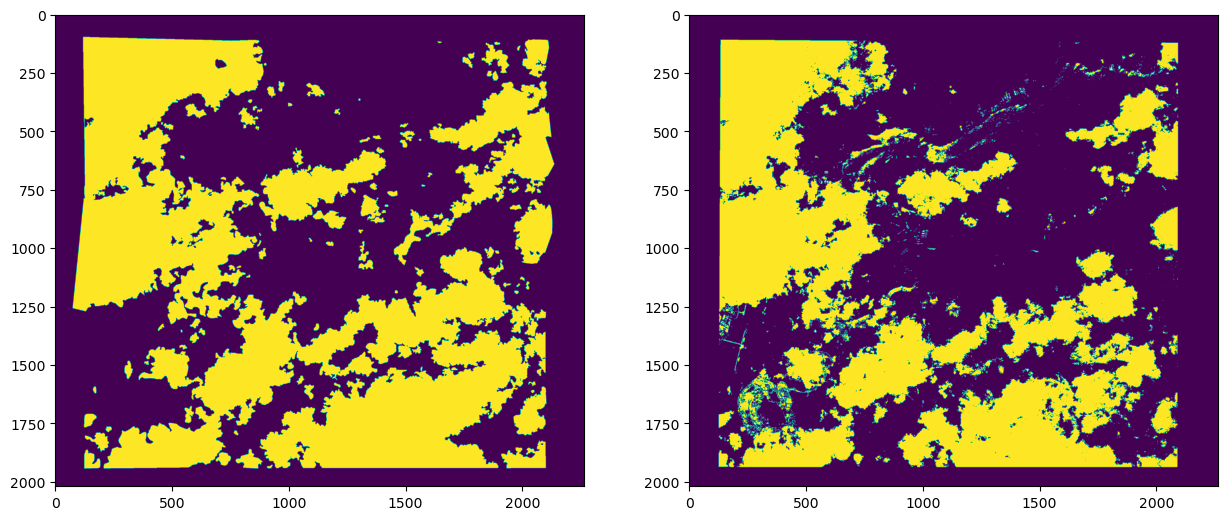

In [73]:
new_mask2 = y_pred2.reshape(shape2)

plt.figure(figsize=(15,15), dpi=100)
plt.subplot(1,2,1)
plt.imshow(label2.reshape(shape2))

plt.subplot(1,2,2)
plt.imshow(new_mask2)

In [65]:
meta2

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 1642,
 'height': 1726,
 'count': 4,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(9.011805381020108e-05, 0.0, 103.83353644285953,
        0.0, -9.012510180366772e-05, 1.3258991831840972)}

In [66]:
save_mask = r"/home/geoai/eodata/cloud_detect_tensorflow/raw_final/final_data/clip_2.tif"
out_meta = meta2
out_meta.update({
    'count': 1,
    'dtype': np.uint8
})
with rasterio.open(save_mask, "w", compress='lzw', **out_meta) as dest:
    dest.write((new_mask2[...,np.newaxis]).swapaxes(0,2).swapaxes(1,2))

In [6]:
saved_weight = r"./saved_weight_xg/XG_weight.json"
xg_class.load_model(saved_weight)

In [67]:
save_path = r"./saved_weight_xg/XG_weight.json"
xg_class.save_model(save_path)